<a href="https://colab.research.google.com/github/timalsinab/Bishal/blob/master/L01_Greedy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [L01: Implementing Greedy TSP](https://docs.google.com/document/d/1JA_CWBXPN6whvJAemnJLvtYJ3Pbk84dTUolWO_QqosA/edit?usp=sharing)
Written by Dr. Jan Pearce, Berea College

Complete the code by meeting all linked requirements and fixing all FIXMEs

## Your Name: FIXME

**SUMMARY**: A brief summary description of the design and implementation, including how much your initial design plan evolved, the final result you achieved and the amount of time you spent as a programmer or programmers in accomplishing these results. This should be no more than two paragraphs.

FIXME

**PERSONNEL**: A description of who you worked with and on what sections.  It is expected that all collaboration is done as pair programming together. Also, note these collaborations in the code section itself.

FIXME

**CHALLENGES**: Descriptions of the largest challenges you overcame and what made them challenging.

FIXME

**INNOVATIONS**: Any innovations that were not specifically required by the assignment. These are not required, but should be highlighted if included.

FIXME

**TESTING**: Describe how you tested this work.

FIXME

**ERRORS**: A list in bulleted form of all known errors and deficiencies.

FIXME

**COMMENTS**: A paragraph or so of your own comments on and reactions to the Lab.

FIXME

## Import Libraries

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from urllib.request import urlopen

### Read data

In [18]:
tspdata = urlopen("https://cs.berea.edu/courses/csc445/data/tsp-48.txt").read().decode('ASCII')
print(tspdata)

48
6734 1453
2233 10
5530 1424
401 841
3082 1644
7608 4458
7573 3716
7265 1268
6898 1885
1112 2049
5468 2606
5989 2873
4706 2674
4612 2035
6347 2683
6107 669
7611 5184
7462 3590
7732 4723
5900 3561
4483 3369
6101 1110
5199 2182
1633 2809
4307 2322
675 1006
7555 4819
7541 3981
3177 756
7352 4506
7545 2801
3245 3305
6426 3173
4608 1198
23 2216
7248 3779
7762 4595
7392 2244
3484 2829
6271 2135
4985 140
1916 1569
7280 4899
7509 3239
10 2676
6807 2993
5185 3258
3023 1942



## TSP Class

/tmp/ipython-input-635960625.py:231: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


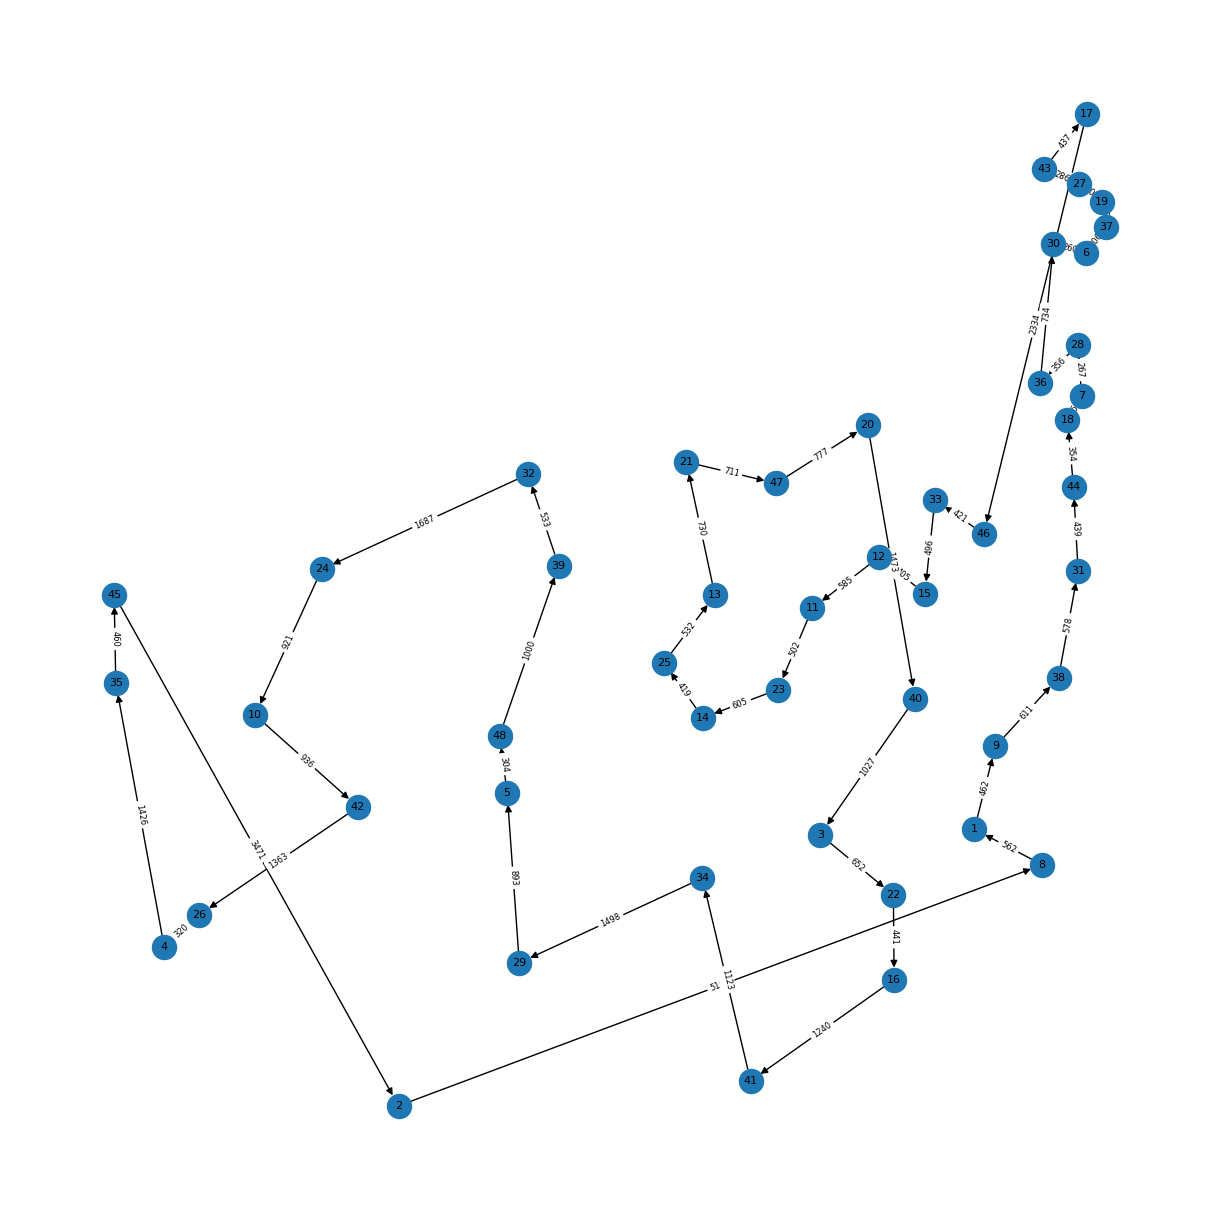

In [21]:
"""

Given certain input, it uses the greedy algorithm to plot a graph and output a file of the solution path
"""
class TSP:

    def __init__(self):
        """ TSP class containing data needed for networkx graph creation, file reading and file writing.
            Creates a graph for the traveling salesperon problem using the greedy algorithm
        """

        self.dimension = None
        self.nodeData = [] # list of tuples (node_id:int, x:float, y:float)
        self.graph = nx.DiGraph()
        self.coords = {} #{node_id:int -> (x:float, y:float)}
        self.places = [] # list of node ids
        self.route = []  # greedy tour order

    def extractData(self, inputFile=""):
        """
        Itterate through the input file and append each coordinate into the node list.
        Keyword Arguments:
            inputFile {str} -- a string for the file name (default: {""})
        """
        self.nodeData.clear()

        # Normalize input to list of stripped lines
        if isinstance(inputFile, list):
            # Already list of (id, x, y)
            for rec in inputFile:
                node, x, y = rec
                self.nodeData.append((int(node), float(x), float(y)))
        else:
            try:
                with open(inputFile, "r", encoding="utf-8") as f:
                    lines = [ln.strip() for ln in f.readlines()]
            except (TypeError, FileNotFoundError, OSError):
                if isinstance(inputFile, str):
                    lines = [ln.strip() for ln in inputFile.splitlines()]
                else:
                    raise ValueError("Unsupported inputFile type for extractData")

            # Drop blank lines
            lines = [ln for ln in lines if ln]

            if not lines:
                self.dimension = 0
                return

            def is_int(s):
                try:
                    int(s); return True
                except: return False

            def is_float(s):
                try:
                    float(s); return True
                except: return False

            # Case A: first nonempty line is a single int N, then N lines of x y
            first = lines[0].split()
            if len(first) == 1 and is_int(first[0]):
                N = int(first[0])
                coords = []
                for ln in lines[1:1+N]:
                    parts = ln.split()
                    if len(parts) >= 2 and is_float(parts[0]) and is_float(parts[1]):
                        coords.append((float(parts[0]), float(parts[1])))
                if len(coords) != N:
                    raise ValueError("Expected N lines of 'x y' after the count.")
                # assign ids 1..N
                self.nodeData = [(i+1, xy[0], xy[1]) for i, xy in enumerate(coords)]

            else:
                # Inspect lines to decide between 'id x y' vs 'x y'
                three_col = all(len(ln.split()) >= 3 for ln in lines)
                two_col = all(len(ln.split()) >= 2 for ln in lines)

                if three_col:
                    for ln in lines:
                        parts = ln.split()
                        if len(parts) >= 3 and is_int(parts[0]) and is_float(parts[1]) and is_float(parts[2]):
                            node = int(parts[0]); x = float(parts[1]); y = float(parts[2])
                            self.nodeData.append((node, x, y))
                elif two_col:
                    # auto-assign ids 1..N
                    tmp = []
                    for ln in lines:
                        parts = ln.split()
                        if len(parts) >= 2 and is_float(parts[0]) and is_float(parts[1]):
                            tmp.append((float(parts[0]), float(parts[1])))
                    self.nodeData = [(i+1, x, y) for i, (x, y) in enumerate(tmp)]
                else:
                    raise ValueError("Unrecognized coordinate format.")

        # Set/verify dimension
        self.dimension = len(self.nodeData)
        # Sort by node id (nice to have)
        self.nodeData.sort(key=lambda t: t[0])

    def setUpCoords(self):
        """ Puts the coordinates for each node into a dictionary as a tuple with the node as the key """
        self.coords = {node: (x, y) for (node, x, y) in self.nodeData}

    def calculateDistance(self, a, b):
        """calculates & returns the distance between points a and b
        Arguments:
            a {[tuple]} -- tuple of numbers for the x and y coordinate of a node
            b {[tuple]} -- tuple of numbers for the x and y coordinate of a node
        Returns:
            [float] -- the distance between the two points using the distance formula
        """
        return math.hypot(a[0] - b[0], a[1] - b[1])

    def getRoute(self, current, visits=[], nVisits=[], needList=True):
        """Makes a list of the nodes to be visited, in order, according to the greedy alogorithm for the TSP
        Arguments:
            current {int} -- the node to start at, not a list index
        Keyword Arguments:
            visits {list} -- list of places already visited (default: {[]})
            nVisits {list} -- list of places not visited (default: {[]})
            needList {bool} -- boolean deciding if the list of places not visited needs to be filled (default: {True})
        """
        if visits is None:
            visits = []
        if nVisits is None:
            nVisits = []

        if needList:
            nVisits = self.listPlaces()

        nVisits = self.cleanUpList(visits, nVisits)

        if not self.route:
            self.route.append(current)
            visits.append(current)
            if current in nVisits:
                nVisits.remove(current)

        while nVisits:
            curr_coords = self.coords[current]
            best_next = min(nVisits, key=lambda c: self.calculateDistance(curr_coords, self.coords[c]))
            self.route.append(best_next)
            visits.append(best_next)
            nVisits.remove(best_next)
            current = best_next

        return visits, nVisits

    def beGreedy(self, start):
        """ puts together the greedy algorithm. Gets the route order and adds the starting place to the end of the route
        Arguments:
            start -- the starting node for the greedy algorithm
        """
        if start not in self.coords:
            raise ValueError(f"Start node {start} not found in coordinates.")
        self.route = []
        self.getRoute(current=start, visits=[], nVisits=[], needList=True)
        if self.route and self.route[0] != self.route[-1]:
            self.route.append(self.route[0])

    def listPlaces(self):
        """makes a list of all the nodes/places from the dictionary
        Returns:
            [list] -- list of all the nodes/places
        """
        self.places = sorted(self.coords.keys())
        return self.places

    def cleanUpList(self, visited, notVisited):
        """removes items in visited from notVisited
        Arguments:
            visited {list}
            notVisited {list}
        Returns:
            [list] -- a list of notVisited - visited
        """

        for item in visited:
            if item in notVisited:
                notVisited.remove(item)
        return notVisited

    def addNodes(self):
        """ adds nodes to the networkx graph
        """

        for everything in self.nodeData:
            node = everything[0]
            self.graph.add_node(node, pos=self.coords[node])

    def addEdges(self):
        """Adds graphs to the networkx graph
        """

        x = 0
        while x < len(self.route)-1:
            self.graph.add_edge(self.route[x], self.route[x+1],
                                weight=self.calculateDistance(self.coords[self.route[x]], self.coords[self.route[x+1]]))
            x += 1

    def showGraph(self):
        """Uses the imported libraries to display the graph
        """
        # get labels and coordinates for the graph
        coords = nx.get_node_attributes(self.graph, 'pos')
        labels = nx.get_edge_attributes(self.graph, 'weight')

        plt.figure(figsize=(12, 12))  # bigger canvas for 48 cities

        # Draw the nodes and edges
        nx.draw(
            self.graph,
            coords,
            with_labels=True,
            node_size=300,     # smaller nodes
            font_size=8,       # smaller labels
            arrowsize=10
        )

        # Round edge labels to whole numbers (or 1 decimal if you prefer)
        rounded_labels = {edge: f"{w:.0f}" for edge, w in labels.items()}

        nx.draw_networkx_edge_labels(
            self.graph,
            coords,
            edge_labels=rounded_labels,
            font_size=6
        )

        plt.tight_layout()
        plt.show()




def main():
    tsp = TSP()

    tsp.extractData(tspdata)
    tsp.setUpCoords()
    tsp.addNodes()
    tsp.beGreedy(1)
    tsp.addEdges()
    tsp.showGraph()


main()